# K-means Clustering

## Manual Implementation

We'll use simple implementation of K-means here to just illustrate some concepts. Then we will use `sklearn` implementation that is more efficient.

In [5]:
import numpy as np
from numpy.linalg import norm


class Kmeans:
    '''Implementing Kmeans algorithm.'''

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initialize_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis=1, ord=2)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)
    
    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
    
    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)

## K-means on Geyser's Eruptions Segmentation

The dataset has 272 observations and 2 features. The data covers the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. We will try to find $K$ subgroups within the data points and group them accordingly. Below is the description of the features:
- eruptions (float): Eruption time in minutes.
- waiting (int):  Waiting time to next eruption.

Let's plot the data first:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

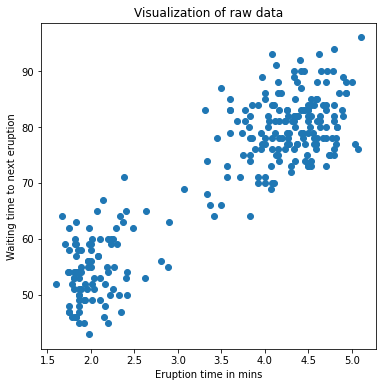

In [7]:
# Import the data
df = pd.read_csv('data/old_faithful.csv')

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption')
plt.title('Visualization of raw data');

We'll use this data because it's easy to plot and visually spot the clusters since its a 2-dimension dataset. It's obvious that we have 2 clusters. Let's standardize the data first and run the k-means algorithm on the standardized data with $K = 2$.

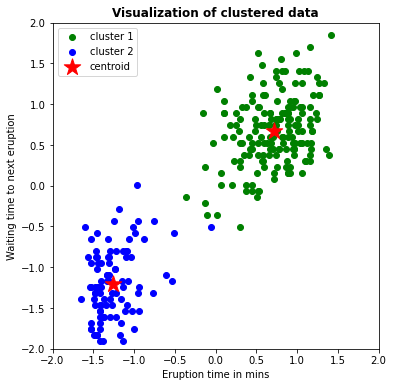

In [8]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = Kmeans(n_clusters=2, max_iter=100)
km.fit(X_std)
centroids = km.centroids

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

The above graph shows the scatter plot of the data colored by the cluster they belong to. In this example, we chose $K = 2$. The symbol **'*'** is the centroid of each cluster. We can think of those 2 clusters as geyser had different kinds of behaviors under different scenarios.

Next, we'll show that different initializations of centroids may yield to different results. I'll use 9 different `random_state` to change the initialization of the centroids and plot the results. The title of each plot will be the sum of squared distance of each initialization.

As a side note, this dataset is considered very easy and converges in less than 10 iterations. Therefore, to see the effect of random initialization on convergence, I am going to go with 3 iterations to illustrate the concept. However, in real world applications, datasets are not at all that clean and nice!

In [ ]:
n_plot = 9
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = np.ravel(ax)
centers = []
for i in range(n_plot):
    # Run local implementation of kmeans
    km = Kmeans(n_clusters=2,
                max_iter=2,
                random_state=np.random.randint(0, 1000, size=1))
    km.fit(X_std)
    centroids = km.centroids
    centers.append(centroids)
    ax[i].scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
                  c='green', label='cluster 1')
    ax[i].scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
                  c='blue', label='cluster 2')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='*', s=300, label='centroid')
    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].legend(loc='lower right')
    ax[i].set_title(f'{km.error:.4f}')
    ax[i].set_aspect('equal')
plt.tight_layout();

As the graph above shows that we only ended up with two different ways of clusterings based on different initializations. We would pick the one with the lowest sum of squared distance.

## K-means on Image Compression

In this part, we'll implement k-means to compress an image. The image that we'll be working on is 392 x 550 x 3. Therefore, for each pixel location we would have 3 8-bit integers that specify the red, green, and blue intensity values. Our goal is to reduce the number of colors to 30 and represent (compress) the photo using those 30 colors only. To pick which colors to use, we'll use k-means algorithm on the image and treat every pixel as a data point. That means reshape the image from height x width x channels to (height * width) x channel. Doing so will allow us to represent the image using the 30 centroids for each pixel and would significantly reduce the size of the image. The difference in size comes from the fact that we'll be using centroids as a lookup for pixels' colors and that would reduce the size of each pixel location.

From now on we will be using `sklearn` implementation of k-means. Few thing to note here:
- `n_init` is the number of times of running the k-means with different centroid's initialization. The result of the best one will be reported.
- `tol` is the within-cluster variation metric used to declare convergence.
- The default of `init` is **k-means++** which is supposed to yield a better results than just random initialization of centroids.

In [ ]:
from sklearn.datasets import (make_blobs, make_circles, make_moons)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# Read the image
img = imread('fig/nd.jpg')
img_size = img.shape

print(img_size)

# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])

# Run the Kmeans algorithm
km = KMeans(n_clusters=30)
km.fit(X)

# Use the centroids to compress the image
X_compressed = km.cluster_centers_[km.labels_]
X_compressed = np.clip(X_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3
X_compressed = X_compressed.reshape(img_size[0], img_size[1], img_size[2])

# Plot the original and the compressed image next to each other
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(X_compressed)
ax[1].set_title('Compressed Image with 30 colors')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout();

We can see the comparison between the original image and the compressed one. The compressed image looks close to the original one which means we're able to retain the majority of the characteristics of the original image. With smaller number of clusters we would have higher compression rate at the expense of image quality. As a side note, this image compression method is called *lossy data compression* because we can't reconstruct the original image from the compressed image.

## Evaluation Methods

Contrary to supervised learning where we have the ground truth to evaluate the model's performance, clustering analysis doesn't have a solid evaluation metric that we can use to evaluate the outcome of different clustering algorithms. Moreover, since k-means requires $k$ as an input and doesn't learn it from data, there is no right answer in terms of the number of clusters that we should have in any problem. Sometimes domain knowledge and intuition may help but usually that is not the case. In the cluster-predict methodology, we can evaluate how well the models are performing based on different $k$ clusters since clusters are used in the downstream modeling.

### Elbow Method

**Elbow** method gives us an idea on what a good $k$ number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters' centroids. We pick $k$ at the spot where SSE starts to flatten out and forming an elbow. We'll use the geyser dataset and evaluate SSE for different values of $k$ and see where the curve might form an elbow and flatten out.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters $k$')
plt.ylabel('Sum of squared distance');

The graph above shows that $k = 2$ is not a bad choice. Sometimes it's still hard to figure out a good number of clusters to use because the curve is monotonically decreasing and may not show any elbow or has an obvious point where the curve starts flattening out.

## Drawbacks

K-means algorithm is good in capturing structure of the data if clusters have a spherical-like shape. It always try to construct a nice spherical shape around the centroid. That means, the minute the clusters have a complicated geometric shapes, k-means does a poor job in clustering the data. We'll illustrate three cases where k-means will not perform well.

First, k-means algorithm doesn't let data points that are far-away from each other share the same cluster even though they obviously belong to the same cluster. Below is an example of data points on two different horizontal lines that illustrates how k-means tries to group half of the data points of each horizontal lines together. 

In [ ]:
# Create horizantal data
X = np.tile(np.linspace(1, 5, 20), 2)
y = np.repeat(np.array([2, 4]), 20)
df = np.c_[X, y]

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X, y)
plt.xlim([0, 6])
plt.ylim([0, 6])
ax.set_aspect('equal')

In [ ]:
# K-means

km = KMeans(n_clusters=2)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X, y, c=labels)
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.text(5.1, 4, 'A', color='red')
plt.text(5.1, 2, 'B', color='red')
plt.text(2.8, 4.1, 'C', color='red')
ax.set_aspect('equal')

K-means considers the point 'B' closer to point 'A' than point 'C' since they have non-spherical shape. Therefore, points 'A' and 'B' will be in the same cluster but point 'C' will be in a different cluster. Note the **Single Linkage** hierarchical clustering method gets this right because it doesn't separate similar points).

Second, we'll generate data from multivariate normal distributions with different means and standard deviations. So we would have 3 groups of data where each group was generated from different multivariate normal distribution (different mean/standard deviation). One group will have a lot more data points than the other two combined. Next, we'll run k-means on the data with $K = 3$ and see if it will be able to cluster the data correctly. To make the comparison easier, I am going to plot first the data colored based on the distribution it came from. Then I will plot the same data but now colored based on the clusters they have been assigned to.

In [ ]:
# Create data from three different multivariate distributions
X_1 = np.random.multivariate_normal(mean=[4, 0], cov=[[1, 0], [0, 1]], size=75)
X_2 = np.random.multivariate_normal(mean=[6, 6], cov=[[2, 0], [0, 2]], size=250)
X_3 = np.random.multivariate_normal(mean=[1, 5], cov=[[1, 0], [0, 2]], size=20)
df = np.concatenate([X_1, X_2, X_3])

# Run kmeans
km = KMeans(n_clusters=3)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].scatter(X_1[:, 0], X_1[:, 1])
ax[0].scatter(X_2[:, 0], X_2[:, 1])
ax[0].scatter(X_3[:, 0], X_3[:, 1])
ax[0].set_aspect('equal')
ax[1].scatter(df[:, 0], df[:, 1], c=labels)
ax[1].scatter(centroids[:, 0], centroids[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centroids):
    ax[1].scatter(c[0], c[1], marker='$%d$' % i, s=50, alpha=1, edgecolor='r')
ax[1].set_aspect('equal')
plt.tight_layout()

Looks like k-means couldn't figure out the clusters correctly. Since it tries to minimize the within-cluster variation, it gives more weight to bigger clusters than smaller ones. In other words, data points in smaller clusters may be left away from the centroid in order to focus more on the larger cluster.

Last, we'll generate data that have complicated geometric shapes such as moons and circles within each other and test k-means on both of the datasets.

In [ ]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    ax[i].scatter(X[0][:, 0], X[0][:, 1])
plt.suptitle('Original data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout()

In [ ]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    km = KMeans(n_clusters=2)
    km.fit(X[0])
    labels = km.predict(X[0])
    centroids = km.cluster_centers_

    ax[i].scatter(X[0][:, 0], X[0][:, 1], c=labels)
    ax[i].scatter(centroids[0, 0], centroids[0, 1], marker='*', s=400, c='r')
    ax[i].scatter(centroids[1, 0], centroids[1, 1], marker='+', s=300, c='green')
plt.suptitle('Simulated data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout()

As expected, k-means couldn't figure out the correct clusters for both datasets.

Let's try Agglomerative clustering with single linkage:

In [ ]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    ac = AgglomerativeClustering(n_clusters = 2, linkage='single',).fit(X[0])
    labels = ac.labels_
    ax[i].scatter(X[0][:, 0], X[0][:, 1], c=labels)
plt.suptitle('Simulated data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout()